## 04. 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

### LinearRegression 클래스 - Ordinary Least Squares

입력 파라미터
- fit_intercept: intercept 값을 계산할 것인지 말지
- normalize: true인 경우 회귀를 수행하기 전에 입력 데이터 세트를 정규화

속성
- coef_
- intercept_

다중공산성 문제: 피처 간의 상관관계가 매우 높은 경우 분산이 매우 커져서 오류에 매우 민감

### 회귀 평가 지표
실제 값과 회귀 예측값의 차이 값을 기반으로 한 지표가 중심

평가지표
- MAE: 실제값과 예측값의 차이를 절댓값으로 변환해 평균
- MSE: 실제값과 예측값의 차이를 제곱해 변환해 평균
- RMSE: MSE에 루트 씌운 것
- R^2: 분산 기반

사이킷런 평가 지표 API
- MAE: metrics.mean_absolute_error
- MSE: metrics.mean_squared_error
- RMSE: metrics.mean_squared_error(squared=False)
- MSLE: metrics.mean_squared_log_error
- R^2: metrics.r2_score

### LinearRegression을 이용해 보스턴 주택 가격 회귀 구현

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

In [32]:
import pandas as pd
import numpy as np

# 현재는 보스턴 데이터셋의 윤리적인 문제로 삭제되어 따로 생성
data_url = "http://lib.stat.cmu.edu/datasets/boston"
columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','PRICE']
bostonDF = pd.read_csv('boston.txt',sep='\s+',header=None)
bostonDF.columns=columns

print('Boston 데이터 세트 크기 :', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


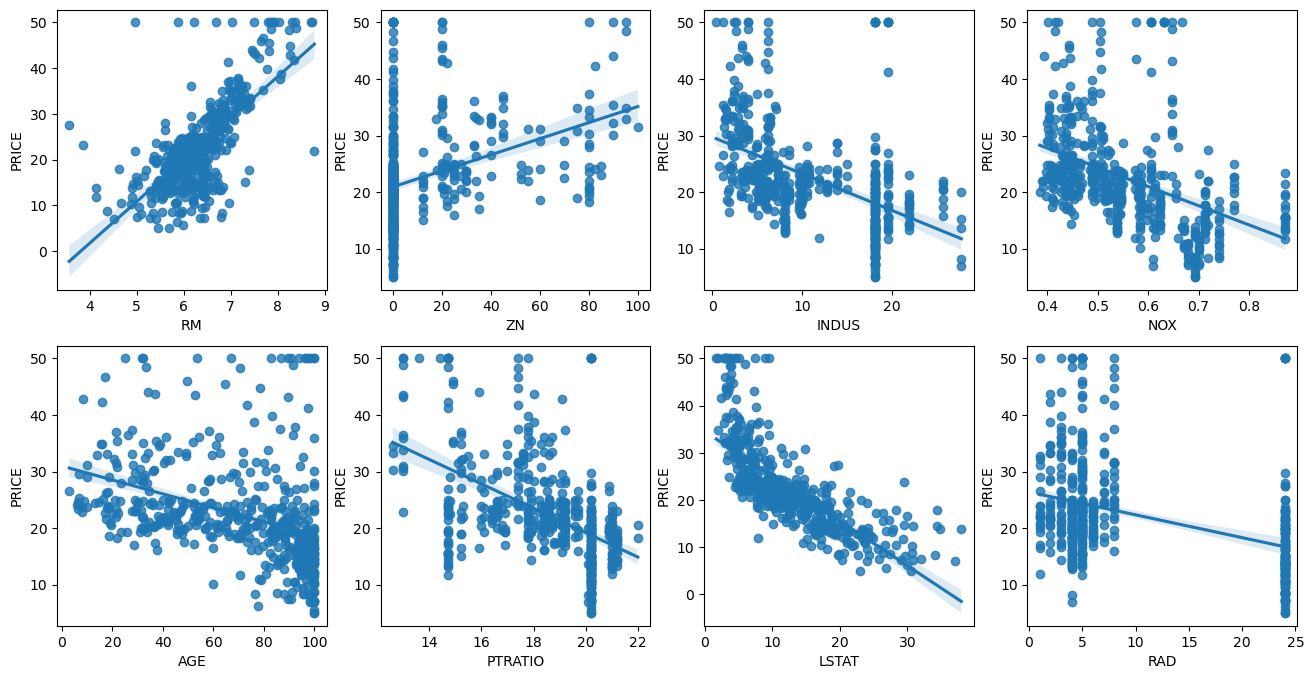

In [34]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

다른 칼럼보다 RM과 LSTAT의 PRICE 영향도가 가장 두드러지게 나타남
- RM: 방의 크기가 클수록 가격이 증가
- LSTAT: 하위 계층 비율이 적을 수록 가격이 증가

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3,
                                                   random_state=156)

# 선형 회귀 OLS로 학습/예측/평가 수행.
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMS : {1:.3f}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297, RMS : 4.159
Variance score : 0.757


In [37]:
print('절편 값:', lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_,1))

절편 값: 40.99559517216445
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [41]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_,1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [42]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

# cross_val_score()로 5 폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함.
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring='neg_mean_squared_error',cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring='neg_mean_squared_error')로 반환된 값은 모두 음수
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores: ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE: {0:.3f}'.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores:  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE: 5.829
